In [1]:
import os
import sys
from glob import glob
import io
import wave
from itertools import cycle
from scipy.stats import spearmanr
from scipy.stats import ttest_ind

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

import librosa
import librosa.display

import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [2]:
current_dir = os.getcwd()

In [3]:
fan_audio_raw_files = glob(current_dir + "/data/fan_*/*/*/*.wav")
pump_audio_raw_files = glob(current_dir + "/data/pump_*/*/*/*.wav")
slider_audio_raw_files = glob(current_dir + "/data/slider_*/*/*/*.wav")
valve_audio_raw_files = glob(current_dir + "/data/valve_*/*/*/*.wav")

In [4]:
print(len(fan_audio_raw_files))
print(len(pump_audio_raw_files))
print(len(slider_audio_raw_files))
print(len(valve_audio_raw_files))

16650
12615
12282
12510


In [5]:
all_raw_audio_files = fan_audio_raw_files + pump_audio_raw_files + slider_audio_raw_files + valve_audio_raw_files

In [ ]:
raw_data_list = [] 
sample_rate_list = []
sound_source_list = [] 
binary_classification_list = [] 
wav_file_list = [] 
name_classification_list = []

for audio_raw_file in all_raw_audio_files:
    split_string = str(audio_raw_file).split('/')
    sound_source = split_string[-4]
    name_classification = sound_source.split("_")[0]
    binary_classification = split_string[-2]
    wav_file = split_string[-1]
    raw_data, sample_rate = librosa.load(audio_raw_file, sr=None)
    sound_source_list.append(sound_source)
    binary_classification_list.append(binary_classification)
    wav_file_list.append(wav_file)
    raw_data_list.append(raw_data)
    sample_rate_list.append(sample_rate)
    name_classification_list.append(name_classification)


df = pd.DataFrame(data={"Sound Source": sound_source_list,
                        "Machine Type": name_classification_list,
                        "Classification": binary_classification_list,
                        ".wav File": wav_file_list,
                        "Sample Rate": sample_rate_list,
                        "Raw Data": raw_data_list})

In [ ]:
df.head(10)

In [ ]:
df.tail(10)

In [ ]:
df.dtypes

In [ ]:
df["label"] = df.apply(lambda row: 1 if row.Classification == "abnormal" else 0, axis=1)

In [7]:
def extract_mfccs(raw_audio, sample_rate, n_mfcc=20):
    # Extract the mfccs as numpy arrays
    mfccs = librosa.feature.mfcc(y=raw_audio, sr=sample_rate, n_mfcc=n_mfcc)

    # Find the average coefficient accross time of the processed audio file in the MFCC sequence
    mfccs_processed = np.mean(mfccs.T, axis=0)
    
    return mfccs_processed


def extract_temporal_features(raw_audio):

    # the rate at which a signal changes from positive to zero to negative or from negative to zero to positive.
    zero_crossing_rate=librosa.feature.zero_crossing_rate(raw_audio)[0]
    
    # Bounded-lag auto-correlation
    # The autocorrelation is useful for finding repeated patterns in a signal.
    # For example, at short lags, the autocorrelation can tell us something about the signal's fundamental frequency.
    # For longer lags, the autocorrelation may tell us something about the tempo of a musical signal.
    autocorrelation = librosa.autocorrelate(raw_audio)
    
    return np.mean(zero_crossing_rate), np.mean(autocorrelation)


def extract_spectral_features(raw_audio, sample_rate):
    
    spectral_centroids = librosa.feature.spectral_centroid(y=raw_audio, sr=sample_rate)[0]
    spectral_rollof = librosa.feature.spectral_rolloff(y=raw_audio, sr=sample_rate)[0]
    spectral_contrast = librosa.feature.spectral_contrast(y=raw_audio, sr=sample_rate)[0]
    
    return np.mean(spectral_centroids), np.mean(spectral_rollof), np.mean(spectral_contrast)

In [ ]:
list_of_mfccs = []
list_temporal_features = []
list_spectral_features = []

for idx, row in df.iterrows():
    result_mfccs = extract_mfccs(row["Raw Data"], row["Sample Rate"])
    result_temporal = extract_temporal_features(row["Raw Data"])
    result_spectral = extract_spectral_features(row["Raw Data"], row["Sample Rate"])
    list_of_mfccs.append(result_mfccs)
    list_temporal_features.append(result_temporal)
    list_spectral_features.append(result_spectral)


# Traditionally the first 13 MFCC's are the most descriptive in signal processing
n_mfcc = 20
mfcc_labels = [f"MFCC_{i+1}" for i in range(n_mfcc)]

# 3 spectral features
spectral_labels = ['spectral_centroid', 'spectral_rolloff', 'spectral_contrast']

# 2 temporal features
temporal_labels = ['zero_crossing_rate', 'autocorrelation']

# Combine all feature labels into a single list
feature_names = mfcc_labels + spectral_labels + temporal_labels

df_mfcc = pd.DataFrame(data=list_of_mfccs, columns=mfcc_labels)
df_spectral = pd.DataFrame(data=list_spectral_features, columns=spectral_labels)
df_temporal = pd.DataFrame(data=list_temporal_features, columns=temporal_labels)

# concatenate the dataframes horizontally
df_features = pd.concat([df_mfcc, df_spectral, df_temporal], axis=1)

df_all_features = pd.merge(df, df_features, left_index=True, right_index=True)

In [10]:
df_all_features.head(5)

,Sound Source,Machine Type,Classification,.wav File,Sample Rate,Raw Data,label,MFCC_1,MFCC_2,MFCC_3,...,MFCC_16,MFCC_17,MFCC_18,MFCC_19,MFCC_20,spectral_centroid,spectral_rolloff,spectral_contrast,zero_crossing_rate,autocorrelation
0,fan_0_db,fan,abnormal,00000059.wav,16000,"[0.009010315, 0.008777618, 0.007923126, 0.0066...",1,-371.859314,113.486099,18.810814,...,0.168235,-0.470244,1.984596,6.285768,2.654916,1266.055936,2858.102037,26.339263,0.042744,0.000043
1,fan_0_db,fan,abnormal,00000071.wav,16000,"[-0.010116577, -0.010787964, -0.011062622, -0....",1,-397.188812,154.759766,-5.939932,...,4.807566,1.653242,1.415375,0.412774,0.533738,824.260416,1657.148562,22.740603,0.029732,0.000045
2,fan_0_db,fan,abnormal,00000065.wav,16000,"[0.020389557, 0.019676208, 0.01964569, 0.01977...",1,-388.468506,129.784851,20.890654,...,0.120793,-7.694414,-1.887065,4.981663,8.837887,1063.434283,1969.324081,26.106510,0.037813,0.000048
3,fan_0_db,fan,abnormal,00000273.wav,16000,"[0.011543274, 0.01014328, 0.011035919, 0.01088...",1,-366.914093,106.355804,17.865118,...,4.231652,-3.307648,-4.035701,-3.882074,-3.099382,1486.769328,3365.065895,21.156002,0.077304,0.000018
4,fan_0_db,fan,abnormal,00000267.wav,16000,"[0.0021133423, 0.0019378662, 0.002155304, 0.00...",1,-419.280609,130.316925,0.243935,...,4.747648,3.382546,2.288590,0.893118,2.209656,1200.572023,2400.683906,22.433544,0.067153,0.000012


In [11]:
df_all_features.tail(5)

,Sound Source,Machine Type,Classification,.wav File,Sample Rate,Raw Data,label,MFCC_1,MFCC_2,MFCC_3,...,MFCC_16,MFCC_17,MFCC_18,MFCC_19,MFCC_20,spectral_centroid,spectral_rolloff,spectral_contrast,zero_crossing_rate,autocorrelation
54052,valve_pos_6_db,valve,normal,00000083.wav,16000,"[-0.0015220642, -0.0024032593, -0.0027389526, ...",0,-461.993317,120.006790,4.047363,...,3.983354,5.578707,-2.271346,-2.386443,0.055717,1354.455519,2729.582668,15.742184,0.075481,0.000004
54053,valve_pos_6_db,valve,normal,00000097.wav,16000,"[-0.0033035278, -0.0030288696, -0.0026435852, ...",0,-467.100433,122.616463,1.585401,...,4.170306,4.880260,-3.512892,-3.420836,0.288180,1297.779951,2619.109425,16.184888,0.071587,0.000004
54054,valve_pos_6_db,valve,normal,00000068.wav,16000,"[-0.0005912781, -1.9073486e-05, 0.00062179565,...",0,-399.985413,46.368267,-6.757586,...,8.408872,1.843847,0.245745,2.056376,0.157858,2730.940755,5277.381190,15.716011,0.258477,0.000003
54055,valve_pos_6_db,valve,normal,00000040.wav,16000,"[-0.00061035156, -0.0008201599, -0.00074768066...",0,-476.076263,123.163536,18.350065,...,1.855357,-0.249104,-0.348117,1.215526,0.913831,1268.054232,2596.270966,15.248544,0.063949,0.000004
54056,valve_pos_6_db,valve,normal,00000054.wav,16000,"[-0.0022010803, -0.0014953613, -0.00020980835,...",0,-445.143768,119.515709,-2.394872,...,4.990331,3.213632,-0.346797,-0.993934,-2.435366,1372.769833,2895.542133,15.384354,0.080554,0.000004


In [ ]:
df_all_features.to_pickle(current_dir + "/data/full_audio_data.pkl")

# Binary Classification: Normal or Abnormal Sounds

In [12]:
# Split dataframes by machine type
df_fan = df_all_features[df_all_features["Machine Type"] == "fan"]
df_pump = df_all_features[df_all_features["Machine Type"] == "pump"]
df_slider = df_all_features[df_all_features["Machine Type"] == "slider"]
df_valve = df_all_features[df_all_features["Machine Type"] == "valve"]

In [13]:
min_max_scaler = preprocessing.MinMaxScaler()
le = LabelEncoder()

### Fans

In [14]:
y_fan = df_fan['label']
y_fan = le.fit_transform(y_fan)

In [15]:
feature_names

['MFCC_1',
 'MFCC_2',
 'MFCC_3',
 'MFCC_4',
 'MFCC_5',
 'MFCC_6',
 'MFCC_7',
 'MFCC_8',
 'MFCC_9',
 'MFCC_10',
 'MFCC_11',
 'MFCC_12',
 'MFCC_13',
 'MFCC_14',
 'MFCC_15',
 'MFCC_16',
 'MFCC_17',
 'MFCC_18',
 'MFCC_19',
 'MFCC_20',
 'spectral_centroid',
 'spectral_rolloff',
 'spectral_contrast',
 'zero_crossing_rate',
 'autocorrelation']

In [16]:
df_fan[feature_names]

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,...,MFCC_16,MFCC_17,MFCC_18,MFCC_19,MFCC_20,spectral_centroid,spectral_rolloff,spectral_contrast,zero_crossing_rate,autocorrelation
0,-371.859314,113.486099,18.810814,17.080877,1.204625,9.886292,11.080414,11.740403,-5.676914,3.241524,...,0.168235,-0.470244,1.984596,6.285768,2.654916,1266.055936,2858.102037,26.339263,0.042744,0.000043
1,-397.188812,154.759766,-5.939932,36.076820,1.171455,16.975294,-1.910571,5.978245,0.101822,6.181811,...,4.807566,1.653242,1.415375,0.412774,0.533738,824.260416,1657.148562,22.740603,0.029732,0.000045
2,-388.468506,129.784851,20.890654,7.433893,8.337717,8.820606,7.673026,11.175337,6.273690,0.861285,...,0.120793,-7.694414,-1.887065,4.981663,8.837887,1063.434283,1969.324081,26.106510,0.037813,0.000048
3,-366.914093,106.355804,17.865118,18.438393,-0.680915,4.703062,7.155754,-0.872129,-2.990783,9.555454,...,4.231652,-3.307648,-4.035701,-3.882074,-3.099382,1486.769328,3365.065895,21.156002,0.077304,0.000018
4,-419.280609,130.316925,0.243935,24.220707,0.952382,10.387427,0.529726,4.714439,1.933908,2.826862,...,4.747648,3.382546,2.288590,0.893118,2.209656,1200.572023,2400.683906,22.433544,0.067153,0.000012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16645,-289.845154,115.345360,-8.021118,25.872128,-0.576749,7.003337,-3.896083,4.549372,-0.550484,4.081668,...,1.510764,-0.128047,0.168220,1.743035,0.791535,1395.047386,2952.600839,17.417328,0.089538,0.000055
16646,-290.003784,116.386360,-6.261634,26.947845,-0.972674,5.020364,-4.700207,4.268027,-2.059419,2.563062,...,0.623116,-0.949848,-1.193861,0.411840,0.851374,1382.261180,2925.344449,17.452538,0.087015,0.000056
16647,-291.225800,115.094711,-6.148879,26.874372,-1.063623,6.478925,-3.760066,5.358610,-0.555379,3.806834,...,1.697564,0.455676,0.949088,1.193066,0.358778,1393.097554,2969.523762,17.881778,0.087430,0.000054
16648,-303.369293,115.575081,-1.230798,25.511805,1.026673,3.466041,-5.279933,1.947524,1.214805,4.300354,...,-0.224103,-1.034999,1.217464,3.748657,1.893888,1373.806433,2969.573682,15.121883,0.085081,0.000051


In [17]:
X_fan = df_fan[feature_names]
cols_fan = X_fan.columns
np_scaled_fan = min_max_scaler.fit_transform(X_fan)


In [18]:
# new data frame with the new scaled data. 
X_fan = pd.DataFrame(np_scaled_fan, columns = cols_fan)

In [19]:
X_train_fan, X_test_fan, y_train_fan, y_test_fan = train_test_split(X_fan,
                                                                    y_fan,
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                    stratify=y_fan,
                                                                    shuffle=True)

In [20]:
# Logistic Regression
lg_fan = LogisticRegression(random_state=16, solver='liblinear', max_iter=5000, multi_class="ovr")
lg_fan.fit(X_train_fan, y_train_fan)
preds_fan = lg_fan.predict(X_test_fan)
#print(confusion_matrix(y_test, preds))
print('Accuracy:', round(accuracy_score(y_test_fan, preds_fan), 5), '\n')
print('Precision:', round(precision_score(y_test_fan, preds_fan, average='binary'), 5), '\n')
print('Recall:', round(recall_score(y_test_fan, preds_fan, average='binary'), 5), '\n')
print('F1 Score:', round(f1_score(y_test_fan, preds_fan, average='binary'), 5), '\n')

Accuracy: 0.83814 

Precision: 0.80565 

Recall: 0.51525 

F1 Score: 0.62853 



In [21]:
cm = confusion_matrix(y_test_fan, preds_fan, labels=lg_fan.classes_)

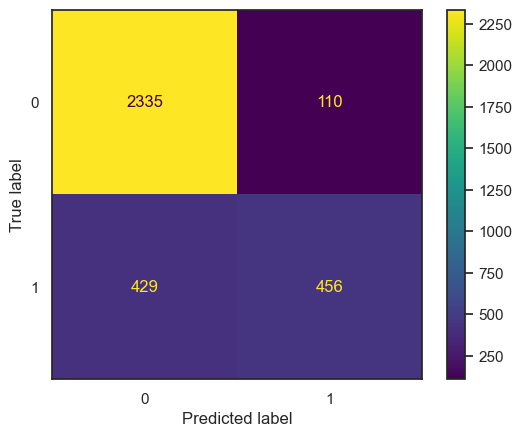

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lg_fan.classes_)
disp.plot()

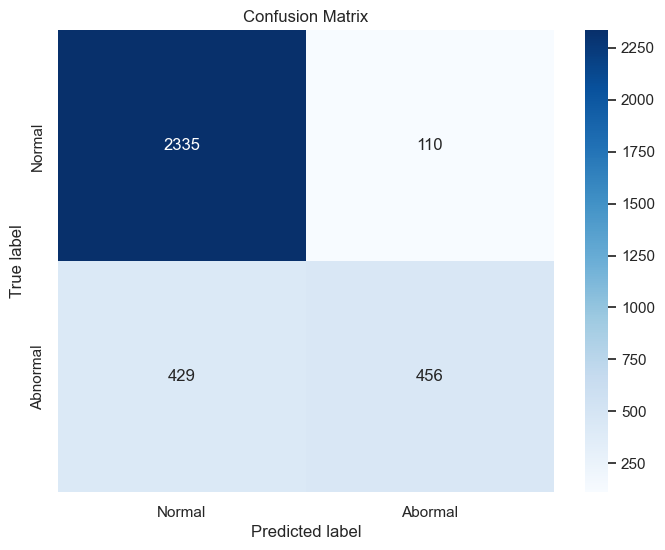

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abormal'], yticklabels=['Normal', 'Abnormal'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

### Stratified k-Fold Cross-Validation for Fans

In [72]:
k_fold_fan = KFold(n_splits=10, shuffle=True, random_state=0)

scores_fan = cross_val_score(estimator=lg_fan,
                              X=X_fan,
                              y=y_fan,
                              groups=None,
                              scoring=None,
                              cv=5,
                              n_jobs=None,
                              verbose=0,
                              error_score=np.nan)

print(f"Cross-validation scores: {scores_fan}")
print(f"Average cross-validation score: {scores_fan.mean():.2f}")

Cross-validation scores: [0.83723724 0.86876877 0.85615616 0.76996997 0.78828829]
Average cross-validation score: 0.82


In [73]:
scores_fan = cross_val_score(estimator=lg_fan,
                              X=X_fan,
                              y=y_fan,
                              groups=None,
                              scoring=None,
                              cv=k_fold_fan,
                              n_jobs=None,
                              verbose=0,
                              error_score=np.nan)

print(f"Cross-validation scores: {scores_fan}")
print(f"Average cross-validation score: {scores_fan.mean():.2f}")

Cross-validation scores: [0.83903904 0.83663664 0.83243243 0.83063063 0.82642643 0.83543544
 0.83903904 0.83783784 0.84204204 0.84324324]
Average cross-validation score: 0.84


### GridSearch Cross-Validation for Fans

In [74]:
param_grid = [
    {'penalty' : ['l1', 'l2'],
     'C' : np.logspace(-4, 4, 20),
     'solver' : ['liblinear']}
]

grid_search = GridSearchCV(estimator=LogisticRegression(),
                           param_grid=param_grid,
                           scoring=None,
                           n_jobs=None,
                           refit=True,
                           cv=None,
                           verbose=0,
                           pre_dispatch='2*n_jobs',
                           error_score=np.nan,
                           return_train_score=False)

grid_search.fit(X_train_fan, y_train_fan)

/opt/anaconda3/envs/dev_tf_audio_class/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/dev_tf_audio_class/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/dev_tf_audio_class/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/dev_tf_audio_class/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/dev_tf_audio_class/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']}])

In [75]:
print(f"Test set score: {grid_search.score(X_test_fan, y_test_fan):.2f}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")
print(f"Best estimator:\n{grid_search.best_estimator_}")

Test set score: 0.85
Best parameters: {'C': 29.763514416313132, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.84
Best estimator:
LogisticRegression(C=29.763514416313132, solver='liblinear')


In [76]:
results = pd.DataFrame(grid_search.cv_results_)
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010521,0.001588,0.001995,0.000396,0.0001,l1,liblinear,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'libl...",0.734234,0.734234,0.734234,0.734234,0.734234,0.734234,0.0,32
1,0.011017,0.000535,0.001522,0.000086,0.0001,l2,liblinear,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'libl...",0.734234,0.734234,0.734234,0.734234,0.734234,0.734234,0.0,32
2,0.006514,0.000262,0.001386,0.000070,0.000264,l1,liblinear,"{'C': 0.00026366508987303583, 'penalty': 'l1',...",0.734234,0.734234,0.734234,0.734234,0.734234,0.734234,0.0,32
3,0.010884,0.000925,0.001377,0.000108,0.000264,l2,liblinear,"{'C': 0.00026366508987303583, 'penalty': 'l2',...",0.734234,0.734234,0.734234,0.734234,0.734234,0.734234,0.0,32
4,0.008054,0.000229,0.001343,0.000030,0.000695,l1,liblinear,"{'C': 0.0006951927961775605, 'penalty': 'l1', ...",0.734234,0.734234,0.734234,0.734234,0.734234,0.734234,0.0,32


### Pumps

In [24]:
y_pump = df_pump['label']
X_pump = df_pump[feature_names]
cols_pump = X_pump.columns
np_scaled_pump = min_max_scaler.fit_transform(X_pump)

In [25]:
# new data frame with the new scaled data. 
X_pump = pd.DataFrame(np_scaled_pump, columns = cols_pump)

In [26]:
X_train_pump, X_test_pump, y_train_pump, y_test_pump = train_test_split(X_pump,
                                                                    y_pump,
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                    stratify=y_pump,
                                                                    shuffle=True)

In [27]:
# Logistic Regression
lg_pump = LogisticRegression(random_state=16, solver='liblinear', max_iter=5000, multi_class="ovr")
lg_pump.fit(X_train_pump, y_train_pump)
preds_pump = lg_fan.predict(X_test_pump)
#print(confusion_matrix(y_test, preds))
print('Accuracy:', round(accuracy_score(y_test_pump, preds_pump), 5), '\n')
print('Precision:', round(precision_score(y_test_pump, preds_pump, average='binary'), 5), '\n')
print('Recall:', round(recall_score(y_test_pump, preds_pump, average='binary'), 5), '\n')
print('F1 Score:', round(f1_score(y_test_pump, preds_pump, average='binary'), 5), '\n')

Accuracy: 0.3805 

Precision: 0.10677 

Recall: 0.63869 

F1 Score: 0.18296 



In [28]:
cm = confusion_matrix(y_test_pump, preds_pump, labels=lg_pump.classes_)

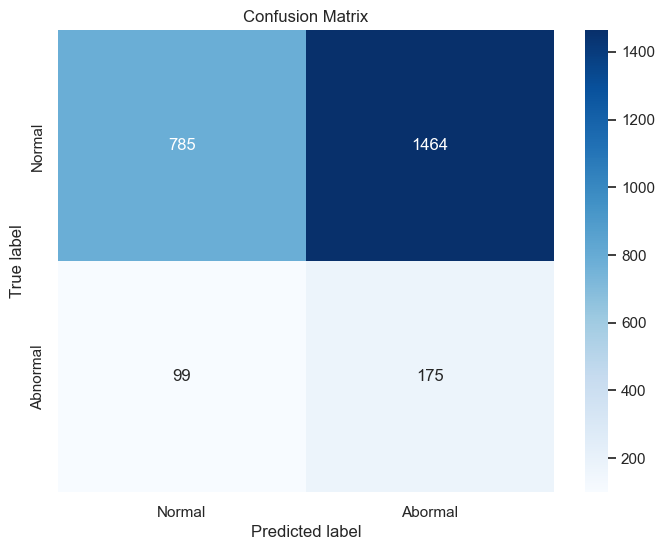

In [29]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abormal'], yticklabels=['Normal', 'Abnormal'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

### Stratified k-Fold Cross-Validation for Pumps

In [67]:
k_fold_pump = KFold(n_splits=10, shuffle=True, random_state=0)

scores_pump = cross_val_score(estimator=lg_pump,
                              X=X_pump,
                              y=y_pump,
                              groups=None,
                              scoring=None,
                              cv=5,
                              n_jobs=None,
                              verbose=0,
                              error_score=np.nan)

print(f"Cross-validation scores: {scores_pump}")
print(f"Average cross-validation score: {scores_pump.mean():.2f}")

Cross-validation scores: [0.921522   0.89774078 0.92310741 0.92667459 0.93499802]
Average cross-validation score: 0.92


In [68]:
scores_pump = cross_val_score(estimator=lg_pump,
                              X=X_pump,
                              y=y_pump,
                              groups=None,
                              scoring=None,
                              cv=k_fold_pump,
                              n_jobs=None,
                              verbose=0,
                              error_score=np.nan)

print(f"Cross-validation scores: {scores_pump}")
print(f"Average cross-validation score: {scores_pump.mean():.2f}")

Cross-validation scores: [0.92789223 0.93106181 0.92551506 0.93106181 0.91442155 0.91990484
 0.92545599 0.93021412 0.91911182 0.91990484]
Average cross-validation score: 0.92


### GridSearch Cross-Validation for Pumps

In [69]:
param_grid = [
    {'penalty' : ['l1', 'l2'],
     'C' : np.logspace(-4, 4, 20),
     'solver' : ['liblinear']}
]

grid_search = GridSearchCV(estimator=LogisticRegression(),
                           param_grid=param_grid,
                           scoring=None,
                           n_jobs=None,
                           refit=True,
                           cv=None,
                           verbose=0,
                           pre_dispatch='2*n_jobs',
                           error_score=np.nan,
                           return_train_score=False)

grid_search.fit(X_train_pump, y_train_pump)

GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']}])

In [70]:
print(f"Test set score: {grid_search.score(X_test_pump, y_test_pump):.2f}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")
print(f"Best estimator:\n{grid_search.best_estimator_}")

Test set score: 0.93
Best parameters: {'C': 78.47599703514607, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.93
Best estimator:
LogisticRegression(C=78.47599703514607, penalty='l1', solver='liblinear')


In [71]:
results = pd.DataFrame(grid_search.cv_results_)
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007852,0.001361,0.002250,0.000339,0.0001,l1,liblinear,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'libl...",0.89153,0.89153,0.891972,0.891477,0.891477,0.891597,0.000189,29
1,0.010841,0.001093,0.001715,0.000152,0.0001,l2,liblinear,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'libl...",0.89153,0.89153,0.891972,0.891477,0.891477,0.891597,0.000189,29
2,0.006228,0.000283,0.001886,0.000137,0.000264,l1,liblinear,"{'C': 0.00026366508987303583, 'penalty': 'l1',...",0.89153,0.89153,0.891972,0.891477,0.891477,0.891597,0.000189,29
3,0.009280,0.000838,0.001548,0.000178,0.000264,l2,liblinear,"{'C': 0.00026366508987303583, 'penalty': 'l2',...",0.89153,0.89153,0.891972,0.891477,0.891477,0.891597,0.000189,29
4,0.007390,0.000562,0.001541,0.000083,0.000695,l1,liblinear,"{'C': 0.0006951927961775605, 'penalty': 'l1', ...",0.89153,0.89153,0.891972,0.891477,0.891477,0.891597,0.000189,29


### Sliders

In [30]:
y_slider = df_slider['label']
X_slider = df_slider[feature_names]
cols_slider = X_slider.columns
np_scaled_slider = min_max_scaler.fit_transform(X_slider)

In [31]:
# new data frame with the new scaled data. 
X_slider = pd.DataFrame(np_scaled_slider, columns = cols_slider)

In [32]:
X_train_slider, X_test_slider, y_train_slider, y_test_slider = train_test_split(X_slider,
                                                                    y_slider,
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                    stratify=y_slider,
                                                                    shuffle=True)

In [33]:
# Logistic Regression
lg_slider = LogisticRegression(random_state=16, solver='liblinear', max_iter=5000, multi_class="ovr")
lg_slider.fit(X_train_slider, y_train_slider)
preds_slider = lg_slider.predict(X_test_slider)
#print(confusion_matrix(y_test, preds))
print('Accuracy:', round(accuracy_score(y_test_slider, preds_slider), 5), '\n')
print('Precision:', round(precision_score(y_test_slider, preds_slider, average='binary'), 5), '\n')
print('Recall:', round(recall_score(y_test_slider, preds_slider, average='binary'), 5), '\n')
print('F1 Score:', round(f1_score(y_test_slider, preds_slider, average='binary'), 5), '\n')

Accuracy: 0.93814 

Precision: 0.95913 

Recall: 0.74719 

F1 Score: 0.84 



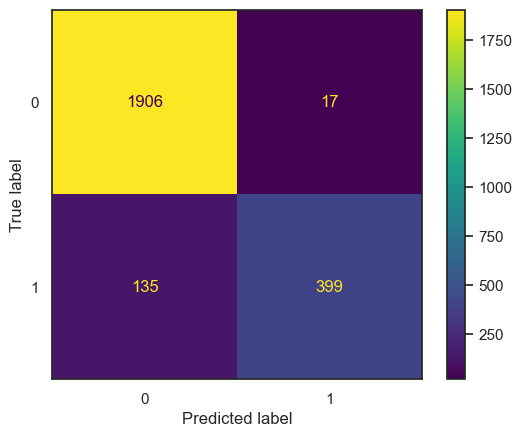

In [34]:
cm = confusion_matrix(y_test_slider, preds_slider, labels=lg_slider.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lg_slider.classes_)
disp.plot()

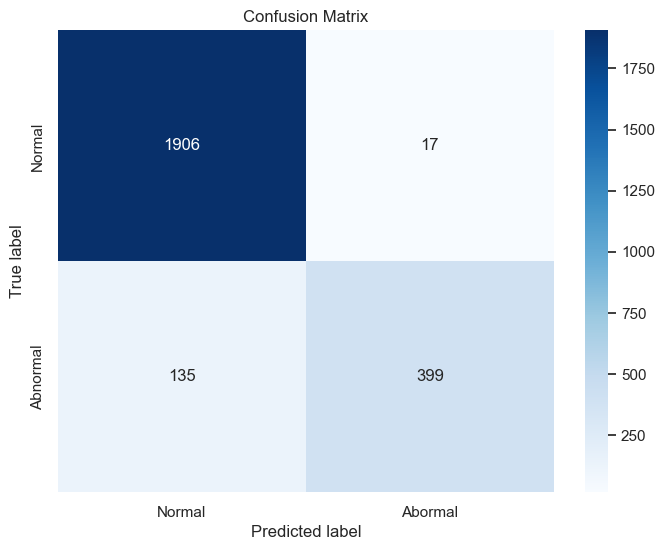

In [35]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abormal'], yticklabels=['Normal', 'Abnormal'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

### Stratified k-Fold Cross-Validation for Sliders 

In [36]:
k_fold_slider = KFold(n_splits=10, shuffle=True, random_state=0)

In [37]:
scores_slider = cross_val_score(estimator=lg_slider,
                              X=X_slider,
                              y=y_slider,
                              groups=None,
                              scoring=None,
                              cv=5,
                              n_jobs=None,
                              verbose=0,
                              error_score=np.nan)

print(f"Cross-validation scores: {scores_slider}")

Cross-validation scores: [0.95482295 0.95482295 0.91368078 0.94381107 0.86604235]


In [38]:
print(f"Average cross-validation score: {scores_slider.mean():.2f}")

Average cross-validation score: 0.93


In [39]:
scores_slider = cross_val_score(estimator=lg_slider,
                              X=X_slider,
                              y=y_slider,
                              groups=None,
                              scoring=None,
                              cv=k_fold_slider,
                              n_jobs=None,
                              verbose=0,
                              error_score=np.nan)

print(f"Cross-validation scores: {scores_slider}")

Cross-validation scores: [0.93246542 0.93002441 0.9242671  0.93648208 0.92915309 0.93729642
 0.9218241  0.93241042 0.94136808 0.93322476]


In [40]:
print(f"Average cross-validation score: {scores_slider.mean():.2f}")

Average cross-validation score: 0.93


### GridSearch Cross-Validation for Sliders

In [62]:
param_grid = [
    {'penalty' : ['l1', 'l2'],
     'C' : np.logspace(-4, 4, 20),
     'solver' : ['liblinear']}
]



In [63]:
grid_search = GridSearchCV(estimator=LogisticRegression(),
                           param_grid=param_grid,
                           scoring=None,
                           n_jobs=None,
                           refit=True,
                           cv=None,
                           verbose=0,
                           pre_dispatch='2*n_jobs',
                           error_score=np.nan,
                           return_train_score=False)

In [64]:
grid_search.fit(X_train_slider, y_train_slider)

GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']}])

In [65]:
print(f"Test set score: {grid_search.score(X_test_slider, y_test_slider):.2f}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")
print(f"Best estimator:\n{grid_search.best_estimator_}")

Test set score: 0.94
Best parameters: {'C': 29.763514416313132, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.93
Best estimator:
LogisticRegression(C=29.763514416313132, solver='liblinear')


In [66]:
results = pd.DataFrame(grid_search.cv_results_)
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007444,0.000704,0.001966,0.000309,0.0001,l1,liblinear,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'libl...",0.782697,0.782697,0.782697,0.782697,0.782188,0.782595,0.000204,32
1,0.009522,0.000898,0.001781,0.000259,0.0001,l2,liblinear,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'libl...",0.782697,0.782697,0.782697,0.782697,0.782188,0.782595,0.000204,32
2,0.005446,0.000461,0.001532,0.000186,0.000264,l1,liblinear,"{'C': 0.00026366508987303583, 'penalty': 'l1',...",0.782697,0.782697,0.782697,0.782697,0.782188,0.782595,0.000204,32
3,0.007898,0.000136,0.001465,0.000107,0.000264,l2,liblinear,"{'C': 0.00026366508987303583, 'penalty': 'l2',...",0.782697,0.782697,0.782697,0.782697,0.782188,0.782595,0.000204,32
4,0.005950,0.000207,0.001353,0.000021,0.000695,l1,liblinear,"{'C': 0.0006951927961775605, 'penalty': 'l1', ...",0.782697,0.782697,0.782697,0.782697,0.782188,0.782595,0.000204,32


### Valves

In [41]:
y_valve = df_valve['label']
X_valve = df_valve[feature_names]
cols_valve = X_valve.columns
np_scaled_valve = min_max_scaler.fit_transform(X_valve)

In [42]:
# new data frame with the new scaled data. 
X_valve = pd.DataFrame(np_scaled_valve, columns = cols_valve)

In [43]:
X_train_valve, X_test_valve, y_train_valve, y_test_valve = train_test_split(X_valve,
                                                                    y_valve,
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                    stratify=y_valve,
                                                                    shuffle=True)

In [44]:
# Logistic Regression
lg_valve = LogisticRegression(random_state=16, solver='liblinear', max_iter=5000, multi_class="ovr")
lg_valve.fit(X_train_valve, y_train_valve)
preds_valve = lg_slider.predict(X_test_valve)
#print(confusion_matrix(y_test, preds))
print('Accuracy:', round(accuracy_score(y_test_valve, preds_valve), 5), '\n')
print('Precision:', round(precision_score(y_test_valve, preds_valve, average='binary'), 5), '\n')
print('Recall:', round(recall_score(y_test_valve, preds_valve, average='binary'), 5), '\n')
print('F1 Score:', round(f1_score(y_test_valve, preds_valve, average='binary'), 5), '\n')

Accuracy: 0.85132 

Precision: 0.11712 

Recall: 0.0453 

F1 Score: 0.06533 



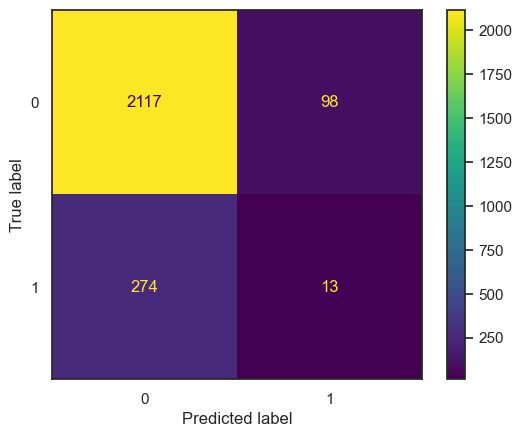

In [45]:
cm = confusion_matrix(y_test_valve, preds_valve, labels=lg_valve.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lg_valve.classes_)
disp.plot()

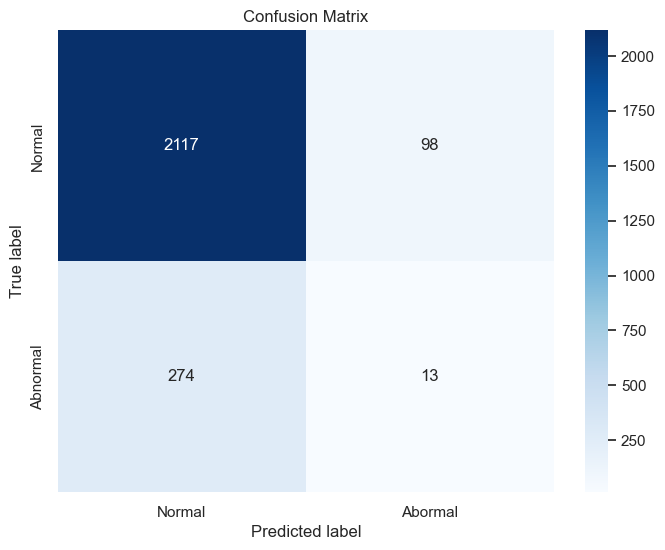

In [46]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abormal'], yticklabels=['Normal', 'Abnormal'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

### Stratified k-Fold Cross-Validation for Valves

In [47]:
k_fold_valve = KFold(n_splits=10, shuffle=True, random_state=0)

In [48]:


scores_pump = cross_val_score(estimator=lg_valve,
                              X=X_valve,
                              y=y_valve,
                              groups=None,
                              scoring=None,
                              cv=None,
                              n_jobs=None,
                              verbose=0,
                              error_score=np.nan)

In [49]:
print(f"Cross-validation scores: {scores_pump}")

Cross-validation scores: [0.88449241 0.88409273 0.882494   0.88449241 0.88489209]


In [50]:
scores_pump = cross_val_score(estimator=lg_valve,
                              X=X_valve,
                              y=y_valve,
                              groups=None,
                              scoring=None,
                              cv=5,
                              n_jobs=None,
                              verbose=0,
                              error_score=np.nan)

print(f"Cross-validation scores: {scores_pump}")

Cross-validation scores: [0.88449241 0.88409273 0.882494   0.88449241 0.88489209]


In [51]:
print(f"Average cross-validation score: {scores_pump.mean():.2f}")

Average cross-validation score: 0.88


In [52]:
scores_pump = cross_val_score(estimator=lg_valve,
                              X=X_valve,
                              y=y_valve,
                              groups=None,
                              scoring=None,
                              cv=k_fold_valve,
                              n_jobs=None,
                              verbose=0,
                              error_score=np.nan)

print(f"Cross-validation scores: {scores_pump}")

Cross-validation scores: [0.90567546 0.882494   0.88968825 0.90167866 0.87130296 0.8745004
 0.88009592 0.88968825 0.8705036  0.88089528]


In [53]:
lg_valve = LogisticRegression(random_state=16, solver='liblinear', max_iter=5000, multi_class="ovr")

lg_valve = LogisticRegression(penalty='l2',
                              dual=False,
                              tol=0.0001,
                              C=1.0,
                              fit_intercept=True,
                              intercept_scaling=1,
                              class_weight=None,
                              random_state=None,
                              solver='lbfgs',
                              max_iter=100,
                              multi_class='deprecated',
                              verbose=0,
                              warm_start=False,
                              n_jobs=None,
                              l1_ratio=None)


param_grid = [
    {'penalty' : ['l1', 'l2'],
     'C' : np.logspace(-4, 4, 20),
     'solver' : ['liblinear']}
]

### GridSearch Cross-Validation for Valves

In [54]:
grid_search = GridSearchCV(estimator=LogisticRegression(),
                           param_grid=param_grid,
                           scoring=None,
                           n_jobs=None,
                           refit=True,
                           cv=None,
                           verbose=0,
                           pre_dispatch='2*n_jobs',
                           error_score=np.nan,
                           return_train_score=False)

In [55]:
grid_search.fit(X_train_valve, y_train_valve)

/opt/anaconda3/envs/dev_tf_audio_class/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']}])

In [56]:
print(f"Test set score: {grid_search.score(X_test_valve, y_test_valve):.2f}")

Test set score: 0.89


In [57]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

Best parameters: {'C': 0.0001, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.89


In [58]:
print(f"Best estimator:\n{grid_search.best_estimator_}")

Best estimator:
LogisticRegression(C=0.0001, penalty='l1', solver='liblinear')


In [59]:
results = pd.DataFrame(grid_search.cv_results_)
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006678,0.002359,0.001484,0.000118,0.0001,l1,liblinear,"{'C': 0.0001, 'penalty': 'l1', 'solver': 'libl...",0.885115,0.885115,0.885115,0.885057,0.885057,0.885092,0.000028,1
1,0.008181,0.000225,0.001398,0.000045,0.0001,l2,liblinear,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'libl...",0.885115,0.885115,0.885115,0.885057,0.885057,0.885092,0.000028,1
2,0.005072,0.000137,0.001367,0.000034,0.000264,l1,liblinear,"{'C': 0.00026366508987303583, 'penalty': 'l1',...",0.885115,0.885115,0.885115,0.885057,0.885057,0.885092,0.000028,1
3,0.009170,0.000495,0.001432,0.000105,0.000264,l2,liblinear,"{'C': 0.00026366508987303583, 'penalty': 'l2',...",0.885115,0.885115,0.885115,0.885057,0.885057,0.885092,0.000028,1
4,0.007716,0.000940,0.001482,0.000106,0.000695,l1,liblinear,"{'C': 0.0006951927961775605, 'penalty': 'l1', ...",0.885115,0.885115,0.885115,0.885057,0.885057,0.885092,0.000028,1
